In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from time import time


from sklearn.metrics import precision_score, recall_score, accuracy_score
# from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.decomposition import PCA
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

In [4]:
paper_data = pd.read_csv("/content/drive/MyDrive/data/CS156Final/paper_data.csv")
citations = pd.read_csv("/content/drive/MyDrive/data/CS156Final/citations.csv")
results = pd.read_csv("/content/drive/MyDrive/data/CS156Final/supervised.csv")

In [5]:
# experiment params
n_pos_vals = np.array([5, 10, 20])
models = [
    DummyClassifier(strategy="constant", constant=0),
    LogisticRegression(),
    RidgeClassifier(),
    SVC(),
    RandomForestClassifier(),
    KNeighborsClassifier(n_neighbors=3),
]

In [6]:
def get_embedding_matrix(series):
    return np.vstack(series.apply(eval).apply(np.array).values)

all_embeddings = get_embedding_matrix(paper_data.embedding)
all_embeddings = StandardScaler().fit_transform(all_embeddings)
print(all_embeddings.shape)

embeddings_pca_10 = PCA(n_components=10).fit_transform(all_embeddings)
print(embeddings_pca_10.shape)
embeddings_pca_50 = PCA(n_components=50).fit_transform(all_embeddings)
print(embeddings_pca_50.shape)

(3086, 768)
(3086, 10)
(3086, 50)


In [7]:
def select_data(embeddings, source_paper, n_positive, n_negative, n_counterexamples=100):
    """Given a source paper, selects the positive and negative training examples and returns positive and negative test sets.
    """
    not_source_papers = np.setdiff1d(np.unique(citations.source), [source_paper])

    reference_group_ids = citations[citations.source == source_paper].target.values
    reference_group_embeddings = embeddings[paper_data.paperId.isin(reference_group_ids)]
    counterexample_group_ids = citations[citations.source.isin(not_source_papers)].target.values
    counterexample_group_embeddings = embeddings[paper_data.paperId.isin(counterexample_group_ids)]

    references_train_idx = np.random.choice(reference_group_embeddings.shape[0], n_positive, replace=False)
    references_train = reference_group_embeddings[references_train_idx, :]
    references_test = reference_group_embeddings[~references_train_idx, :]

    counterexample_train_idx = np.random.choice(counterexample_group_embeddings.shape[0], n_negative, replace=False)
    counterexample_train = counterexample_group_embeddings[counterexample_train_idx, :]
    counterexample_test_idx = np.random.choice(counterexample_group_embeddings.shape[0], n_counterexamples, replace=False)
    counterexample_test = counterexample_group_embeddings[counterexample_test_idx, :]

    return references_train, references_test, counterexample_train, counterexample_test

In [8]:
def make_name(model):
    if isinstance(model, Pipeline):
        return "+".join(make_name(step) for step in model.named_steps.values())
    else:
        return str(model)

In [9]:
def score_supervised(models, embeddings, n_positive, n_negative):

    precision = np.zeros([len(np.unique(citations.source)), len(models)])
    recall = np.zeros_like(precision)
    train_accuracy = np.zeros_like(precision)
    test_accuracy = np.zeros_like(precision)

    training_time = np.zeros_like(precision)
    inference_time = np.zeros_like(precision)

    n_reference_groups = 0

    for i, source_paper in enumerate(np.unique(citations.source)):
        try:
            good_train, good_test, bad_train, bad_test = select_data(embeddings, source_paper, n_positive, n_negative)
            n_reference_groups += 1
        except ValueError:
            continue
        
        # assemble dataset
        y_train = np.array([1] * len(good_train) + [0] * len(bad_train))
        X_train = np.vstack([good_train, bad_train])
        y_test = np.array([1] * len(good_test) + [0] * len(bad_test))
        X_test = np.vstack([good_test, bad_test])

        for j, model in enumerate(models):
            # train model
            start = time()
            model = model.fit(X_train, y_train)
            training_time[i, j] = time() - start

            # inference
            start = time()
            Y_train_pred = model.predict(X_train)
            y_pred = model.predict(X_test)
            inference_time[i, j] = time() - start

            # evaluate model
            precision[i, j] = precision_score(y_test, y_pred)
            recall[i, j] = recall_score(y_test, y_pred)
            train_accuracy[i, j] = accuracy_score(y_train, Y_train_pred)
            test_accuracy[i, j] = accuracy_score(y_test, y_pred)
    
    results = pd.DataFrame()
    results["model"] = [make_name(model) for model in models]
    results["n_reference_groups"] = n_reference_groups
    results["n_positive"] = n_positive
    results["n_negative"] = n_negative

    results["train_accuracy"] = train_accuracy.var(axis=0)
    results["test_accuracy"] = test_accuracy.var(axis=0)
    results["precision"] = precision.var(axis=0)
    results["recall"] = recall.var(axis=0)

    results["training_time"] = training_time.var(axis=0)
    results["inference_time"] = inference_time.var(axis=0)

    return results

In [10]:
def run_experiment(models, n_pos, embedding):
    n_pos_runs = np.hstack([n_pos]*3)
    n_neg_runs = np.maximum(1, np.hstack([
        n_pos_runs,
        (n_pos_runs * 0.5)//1,
        (n_pos_runs * 2)//1,
    ]).astype(int))

    experiment_results = []
    for n_pos, n_neg in zip(n_pos_runs, n_neg_runs):
        experiment_results.append(score_supervised(models, embedding, n_pos, n_neg))
    experiment_results = pd.concat(experiment_results, ignore_index=True)

    return experiment_results

In [11]:
embeddings = {
    "pca_10": embeddings_pca_10,
    "pca_50": embeddings_pca_50,
    "specter": all_embeddings,
}

all_results = []
for embedding_name, embedding in embeddings.items():
    these_results = run_experiment(models, n_pos_vals, embedding)
    these_results["embedding"] = embedding_name
    all_results.append(these_results)
results = pd.concat(all_results, ignore_index=True)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined a

In [15]:
results.head()

,model,n_reference_groups,n_positive,n_negative,train_accuracy,test_accuracy,precision,recall,training_time,inference_time,embedding
0,"DummyClassifier(constant=0, strategy='constant')",60,5,5,0.000000,2.083086e-30,0.000000,0.000000,5.566613e-10,1.249901e-10,pca_10
1,LogisticRegression(),60,5,5,0.000656,2.545314e-02,0.007553,0.036622,5.017930e-06,2.355164e-09,pca_10
2,RidgeClassifier(),60,5,5,0.000656,2.620496e-02,0.005846,0.040122,6.797626e-07,4.273475e-09,pca_10
3,SVC(),60,5,5,0.001497,2.070171e-02,0.022265,0.029900,7.429304e-08,5.290165e-08,pca_10
4,RandomForestClassifier(),60,5,5,0.000000,2.183361e-02,0.005836,0.047056,9.972128e-05,1.802002e-05,pca_10


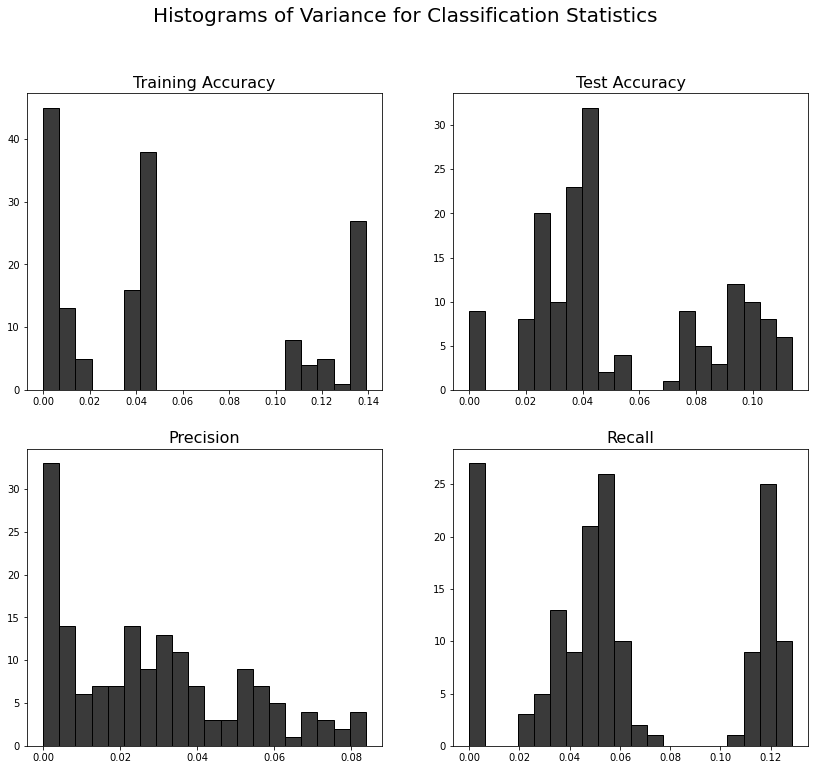

In [28]:

fig, ax = plt.subplots(2, 2, figsize=(14, 12))
fig.suptitle("Histograms of Variance for Classification Statistics", fontsize=20)
ax[0, 0].hist(results['train_accuracy'], ec='black', color='#3a3a3a', bins=20)
ax[0, 0].set_title("Training Accuracy", fontsize=16)

ax[0, 1].hist(results['test_accuracy'], ec='black', color='#3a3a3a', bins=20)
ax[0, 1].set_title("Test Accuracy", fontsize=16)

ax[1, 0].hist(results['precision'], ec='black', color='#3a3a3a', bins=20)
ax[1, 0].set_title("Precision", fontsize=16)

ax[1, 1].hist(results['recall'], ec='black', color='#3a3a3a', bins=20)
ax[1, 1].set_title("Recall", fontsize=16)

plt.show()